### Identifying Pneumonia Patients based on X-Ray Images

**Deanna Gould**  
Phase 4 Flex Student  
Instructor: Morgan Jones  
Presentation Date: September 27, 2023

### Overview

HealthWorx is a telehealth company that would like to be able to diagnose patients with pneumonia from an X-Ray. X-Ray images can be taken in several locations, and this could decrease wait times for patients. Based on the [CDC Website](https://www.cdc.gov/nchs/fastats/pneumonia.htm), 41,309 people die from pneumonia each year, and 1.5 million people visit the emergency room with pneumonia as the primary diagnosis. Emergency rooms are known for their long wait times and becoming overcrowded, so this could also improve other patient's experiences. Pneumonia can have long-lasting effects on the health and well-being of patients. This jupyter notebook will take steps to predict whether a patient has pneumonia or not by using neural networks and image classification of X-Ray images. Although this wouldn't be able to completely replace a doctor's part in diagnosing the patient, this could be used as an added precaution. 

The dataset consists of 4,818 images for train data, 418 images for test data, and 624 images for validation data. Different algorithms like  will be used and each model will be tuned to determine the best model. Binary cross-entropy will be used as the loss function because this is a binary classification problem. For evaluation metrics, accuracy score, recall, and precision will be considered, but recall will be most important because pneumonia is a health-risk. Recall is the number of true positives divided by the number of true positives and false negatives. A false negative can be detrimental in healthcare settings.

### Importing Libraries

In [1]:
# Importing libraries

import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import (plot_confusion_matrix, confusion_matrix, classification_report, roc_curve, auc, 
                             RocCurveDisplay)
import tensorflow as tf
from tensorboard.plugins.hparams import api as hp
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers

### Creating Functions

In [2]:
# Creating a function called plot history

def plot_history(history):
    acc = history.history['binary_accuracy']
    val_acc = history.history['val_binary_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(acc))
    plt.plot(epochs, acc, 'pink', label='Training accuracy')
    plt.plot(epochs, val_acc, 'blue', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.figure()
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.figure()
    plt.show();

In [3]:
# Creating a function for rocauc
# Plot will have true positives on y and false positive values on X, with the ROC line being curved, and the AUC 
# being a straight line.

def plot_roc_auc(y_true, y_score):
    fpr, tpr, thresholds = roc_curve(y_true, y_score)

    print('AUC: {}'.format(auc(fpr, tpr)))
    plt.figure(figsize=(10, 8))
    lw = 2
    plt.plot(fpr, tpr, color='blue',
         lw=lw, label='ROC curve')
    plt.plot([0, 1], [0, 1], color='pink', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.yticks([i/20.0 for i in range(21)])
    plt.xticks([i/20.0 for i in range(21)])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic (ROC) Curve')
    plt.legend(loc='lower right');
    plt.show();

In [4]:
# Creating a function

# Code below from stack overflow
# https://stackoverflow.com/questions/45413712/keras-get-true-labels-y-test-from-imagedatagenerator-or-predict%20%20%20%20%20-generator/67282636#67282636

def pred_labels(model, generator):

# Create lists for storing the predictions and labels
# Labels in this case are actual values and predictions are predicted values
    predictions = []
    labels = []

# Get the total number of labels in generator 
# (i.e. the length of the dataset where the generator generates batches from)
    n = len(generator.labels)

# Loop over the generator
    for data, label in generator:
    # Make predictions on data using the model. Store the results.
        predictions.extend(model.predict(data, workers = 4).flatten())

    # Store corresponding labels
        labels.extend(label)

    # We have to break out from the generator when we've processed 
    # the entire once (otherwise we would end up with duplicates). 
        if (len(label) < generator.batch_size) and (len(predictions) == n):
            break
    return labels, predictions

In [5]:
#Creating a function to plot 
def conf_matrix(y_true, y_pred):

    #Converting probabilities to 0 and 1
    y_pred = np.array([round(x) for x in y_pred])
    
    cm = confusion_matrix(y_true, y_pred)
    
    #Plotting confusion matrix using heatmap
    fig, ax = plt.subplots(figsize = (8, 6))
    ax = sns.heatmap(cm, annot=True, cmap='flare', fmt='g')

    ax.set_title('Predictions for Pneumonia cases\n\n');
    ax.set_xlabel('\nPredicted Values')
    ax.set_ylabel('Actual Values ');

    ## Ticket labels - List must be in alphabetical order
    ax.xaxis.set_ticklabels(['Normal','Pneumonia'])
    ax.yaxis.set_ticklabels(['Normal','Pneumonia'])

    ## Display the visualization of the Confusion Matrix.
    plt.show();
    
    #Calculating normalization
    row_sums = cm.sum(axis=1)
    new_matrix = np.round(cm / row_sums[:, np.newaxis], 3)
    
    #Plotting confusion matrix using heatmap
    fig, ax = plt.subplots(figsize = (8, 6))
    ax = sns.heatmap(new_matrix, annot=True, cmap='flare', fmt='g')

    ax.set_title('Predictions for Pneumonia cases\n\n')
    ax.set_xlabel('\nPredicted Values')
    ax.set_ylabel('Actual Values ');

    ## Ticket labels - List must be in alphabetical order
    ax.xaxis.set_ticklabels(['Normal','Pneumonia'])
    ax.yaxis.set_ticklabels(['Normal','Pneumonia'])

    ## Display the visualization of the Confusion Matrix.
    plt.show();

In [6]:
# Making directories for train test and validation sets

train_dir = "data/chest_xray/chest_xray/train"
val_dir = "data/chest_xray/chest_xray/val"
test_dir = "data/chest_xray/chest_xray/test"

In [7]:
# Getting value counts for each directory

print('train_set:')
print('---------')
pneu_count_tr = len(os.listdir(os.path.join(train_dir, 'PNEUMONIA')))
normal_count_tr = len(os.listdir(os.path.join(train_dir, 'NORMAL')))
print(f'Pneumonia = {pneu_count_tr}')
print(f'Normal = {normal_count_tr}')
print('\n')
print('val_set:')
print('---------')
pneu_count_val = len(os.listdir(os.path.join(val_dir, 'PNEUMONIA')))
normal_count_val = len(os.listdir(os.path.join(val_dir, 'NORMAL')))
print(f'Pneumonia = {pneu_count_val}')
print(f'Normal = {normal_count_val}')
print('\n')
print('test_set:')
print('---------')
pneu_count_test = len(os.listdir(os.path.join(test_dir, 'PNEUMONIA')))
normal_count_test = len(os.listdir(os.path.join(test_dir, 'NORMAL')))
print(f'Pneumonia = {pneu_count_test}')
print(f'Normal = {normal_count_test}')
print('\n') 

train_set:
---------
Pneumonia = 3476
Normal = 942


val_set:
---------
Pneumonia = 409
Normal = 409


test_set:
---------
Pneumonia = 390
Normal = 234




It's important to look at the counts of a dataset. Originally, this dataset had only 16 X-Ray images in the validation dataset, so 401 were moved from the train set to the validation set. Still, there are significantly more X-Ray images that show pneumonia than those that don't, which means that the classes need to be weighted. 

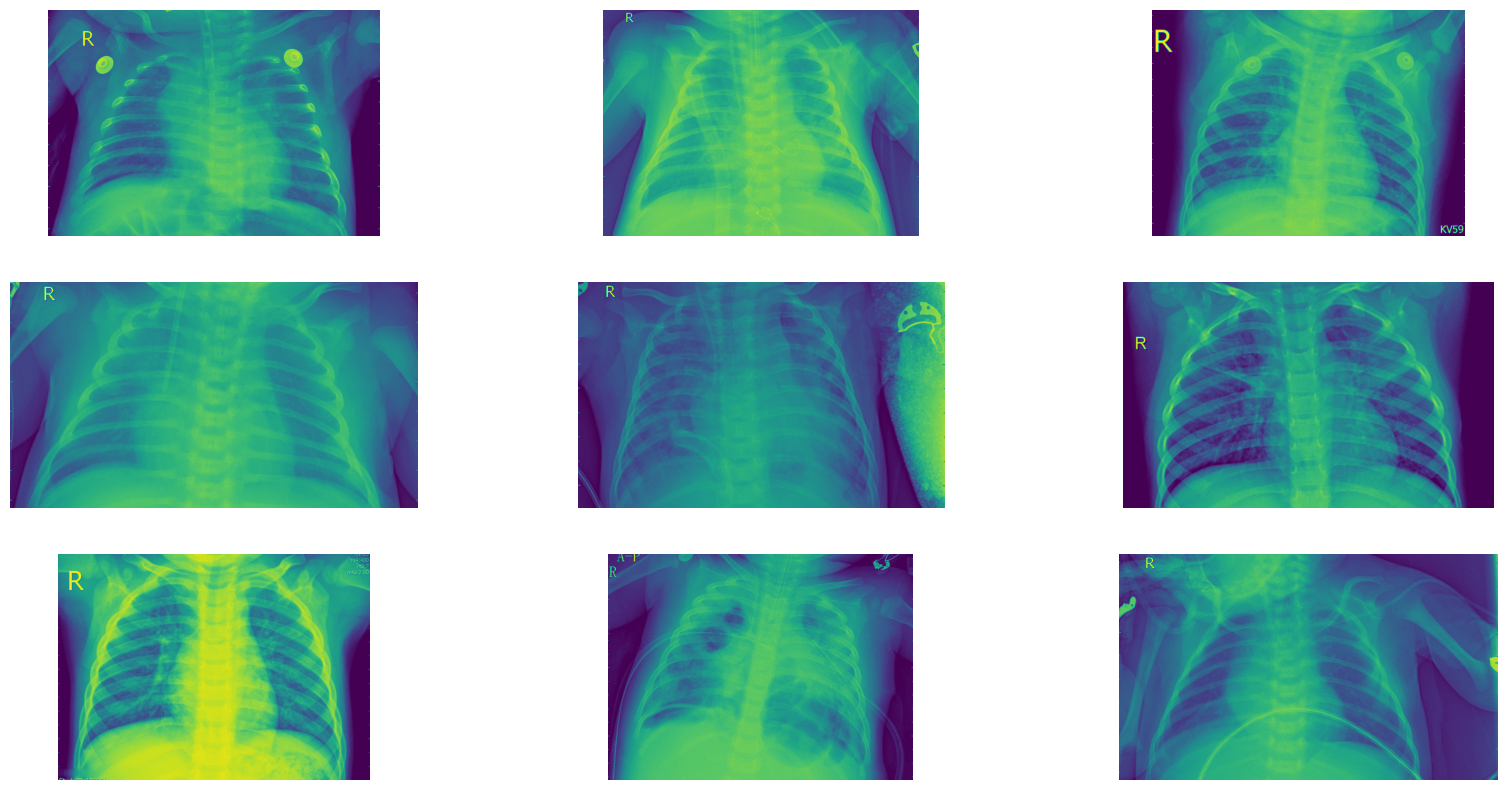

In [8]:
# Displaying pneumonia X-rays
pneumonia = os.listdir("data/chest_xray/chest_xray/train/PNEUMONIA")
pneumoniadir = "data/chest_xray/chest_xray/train/PNEUMONIA"


# Plotting the X-rays
plt.figure(figsize = (20, 10))
for i in range(9):
    plt.subplot(3, 3, i+1)
    image = plt.imread(os.path.join(pneumoniadir, pneumonia[i]))
    plt.imshow(image)
    plt.axis('off')

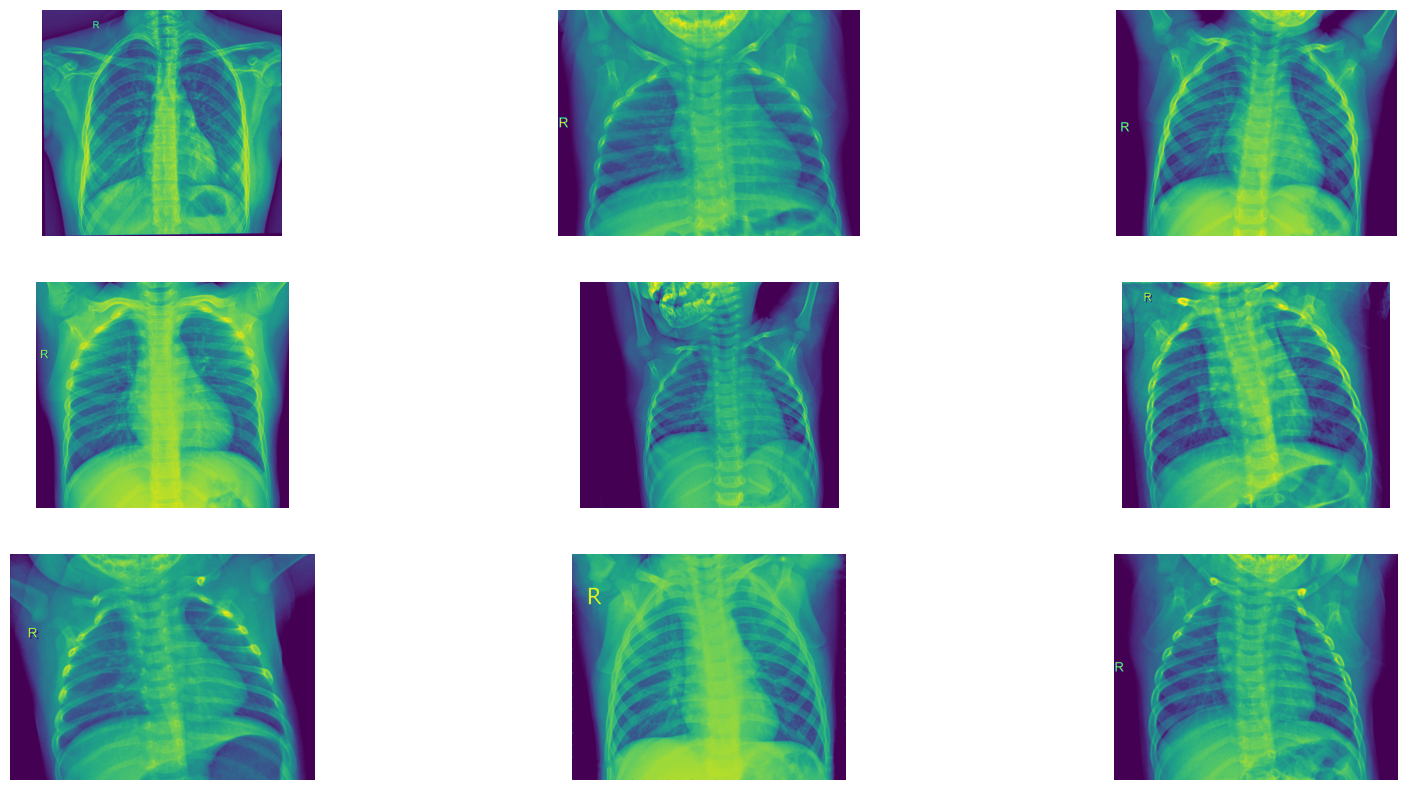

In [9]:
# Displaying normal X-rays
normal = os.listdir("data/chest_xray/chest_xray/train/NORMAL")
normaldir = "data/chest_xray/chest_xray/train/NORMAL"

plt.figure(figsize = (20, 10))
for i in range(9):
    plt.subplot(3, 3, i+1)
    image = plt.imread(os.path.join(normaldir, normal[i]))
    plt.imshow(image)
    plt.axis('off')

As we can see, the pneumonia images seem to be a little more hazy and less clear, but the X-Ray images are a little difficult to read. Though there aren't many untrained human eyes looking at the X-Rays, it can still be confusing for healthcare providers.

In [10]:
# Reading the normal images

normal_img = plt.imread(os.path.join(normaldir, normal[0]))
normal_img

array([[ 0, 23, 24, ...,  0,  0,  0],
       [ 0,  5, 23, ...,  0,  0,  0],
       [ 1,  0, 26, ...,  0,  0,  0],
       ...,
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0]], dtype=uint8)

In [11]:
# Reading the pneumonia images

pneumonia_img = plt.imread(os.path.join(pneumoniadir, pneumonia[0]))
pneumonia_img

array([[ 0,  0,  0, ..., 47, 46, 45],
       [ 0,  0,  0, ..., 45, 45, 45],
       [ 2,  1,  0, ..., 47, 47, 47],
       ...,
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0]], dtype=uint8)

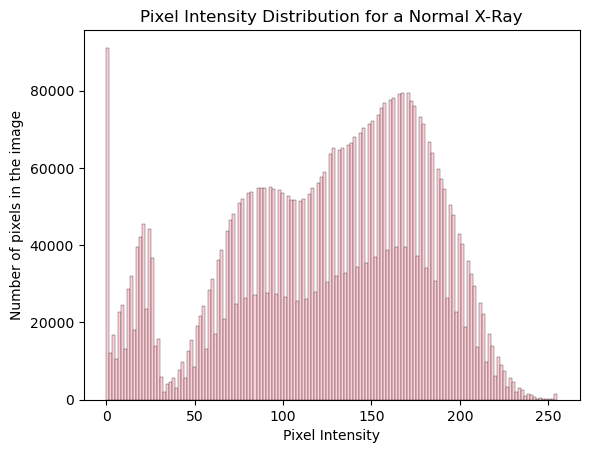

In [12]:
# Plotting the pixels of the images

sns.histplot(normal_img.ravel(), color = 'pink', bins = 150)
plt.title('Pixel Intensity Distribution for a Normal X-Ray')
plt.xlabel('Pixel Intensity')
plt.ylabel('Number of pixels in the image')
plt.show();

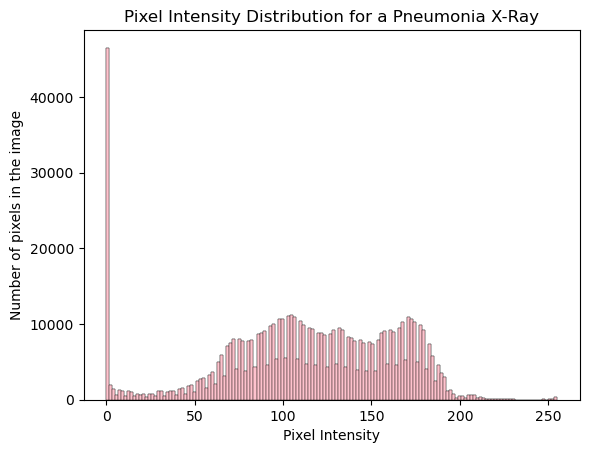

In [13]:
# Plotting the pixels of pneumonia images

sns.histplot(pneumonia_img.ravel(), color = 'pink', bins = 150)
plt.title('Pixel Intensity Distribution for a Pneumonia X-Ray')
plt.xlabel('Pixel Intensity')
plt.ylabel('Number of pixels in the image')
sns.histplot(pneumonia_img.ravel(), color = 'pink', bins = 150);

### Image Generator

In [14]:
# Separating train and val datagen

train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(train_dir, 
                                                    target_size=(224, 224), 
                                                    batch_size=32,
                                                    class_mode='binary',
                                                    shuffle = True)


validation_generator = val_datagen.flow_from_directory(val_dir,
                                                        target_size=(224, 224),
                                                        batch_size=32,
                                                        class_mode='binary',
                                                        shuffle = True)

Found 4416 images belonging to 2 classes.
Found 816 images belonging to 2 classes.


In [15]:
# Checking available classes for the validation generator

validation_generator.class_indices

{'NORMAL': 0, 'PNEUMONIA': 1}

In [16]:
# Getting class weights

weight_pneu = pneu_count_tr / (pneu_count_tr + normal_count_tr)

weight_normal = normal_count_tr / (pneu_count_tr + normal_count_tr)

class_weight = {0 : weight_pneu, 1 : weight_normal}
print(f'0 Weight Class = {weight_pneu}')
print(f'1 Weight Class = {weight_normal}')

0 Weight Class = 0.7867813490267089
1 Weight Class = 0.21321865097329107


### Baseline Model

In [17]:
#Initiating the model
modelone = models.Sequential()

# Input layer
modelone.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(224, 224, 3)))
modelone.add(layers.MaxPooling2D((2, 2)))

#Hidden Layer
modelone.add(layers.Flatten())
modelone.add(layers.Dense(64, activation='relu'))

#Output Layer
modelone.add(layers.Dense(1, activation='sigmoid'))

modelone.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(learning_rate=1e-4),
              metrics=tf.keras.metrics.BinaryAccuracy(name="binary_accuracy", dtype=None, threshold=0.5)
                )

2023-09-27 08:24:09.332802: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN)to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-27 08:24:09.357909: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fd5df598050 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2023-09-27 08:24:09.357927: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version


In [18]:
# Getting summary for model one

modelone.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 111, 111, 32)      0         
_________________________________________________________________
flatten (Flatten)            (None, 394272)            0         
_________________________________________________________________
dense (Dense)                (None, 64)                25233472  
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 25,234,433
Trainable params: 25,234,433
Non-trainable params: 0
_________________________________________________________________


In [19]:
# Fitting the first model

historyone = modelone.fit(train_generator, 
                              epochs=10, 
                              validation_data=validation_generator,
                              class_weight = class_weight,
                              steps_per_epoch = 100,
                              validation_steps=10)

Epoch 1/10
100/100 [==============================] - 89s 892ms/step - loss: 0.2130 - binary_accuracy: 0.7000 - val_loss: 0.2808 - val_binary_accuracy: 0.9000
Epoch 2/10
100/100 [==============================] - 87s 874ms/step - loss: 0.0939 - binary_accuracy: 0.8716 - val_loss: 0.2431 - val_binary_accuracy: 0.9031
Epoch 3/10
100/100 [==============================] - 89s 886ms/step - loss: 0.0701 - binary_accuracy: 0.9153 - val_loss: 0.1926 - val_binary_accuracy: 0.9219
Epoch 4/10
100/100 [==============================] - 106s 1s/step - loss: 0.0591 - binary_accuracy: 0.9247 - val_loss: 0.1505 - val_binary_accuracy: 0.9500
Epoch 5/10
100/100 [==============================] - 110s 1s/step - loss: 0.0456 - binary_accuracy: 0.9459 - val_loss: 0.1192 - val_binary_accuracy: 0.9594
Epoch 6/10
100/100 [==============================] - 109s 1s/step - loss: 0.0405 - binary_accuracy: 0.9506 - val_loss: 0.1131 - val_binary_accuracy: 0.9594
Epoch 7/10
100/100 [==============================] 

#### Baseline Training Validation Accuracy

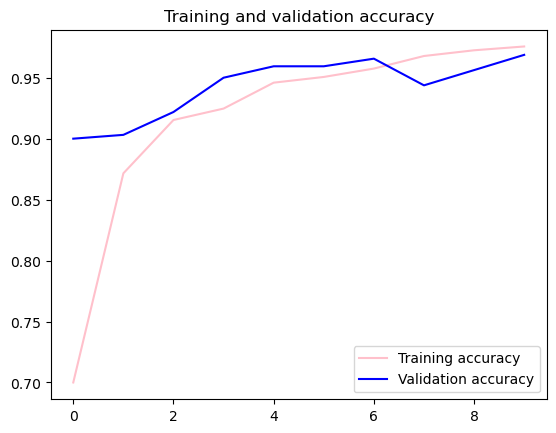

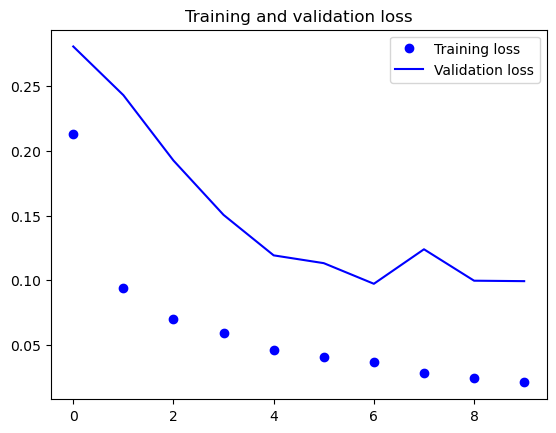

<Figure size 640x480 with 0 Axes>

In [20]:
# Plotting history for model one

plot_history(historyone)

In this first baseline model, the first graph which plots training and validation accuracy. The model is fitting to the training set much better than the validation set. The validation accuracy line is muore jagged and inconsistent than the training set. When looking at loss, the training loss is more jagged and inconsistent, and the width between the two plots are more than I would hope.

### Baseline Predictions Check

In [21]:
# Calling pred_labels to see performance of model 1

modelone_predsval = pred_labels(modelone, validation_generator)

AUC: 0.9956867550941946


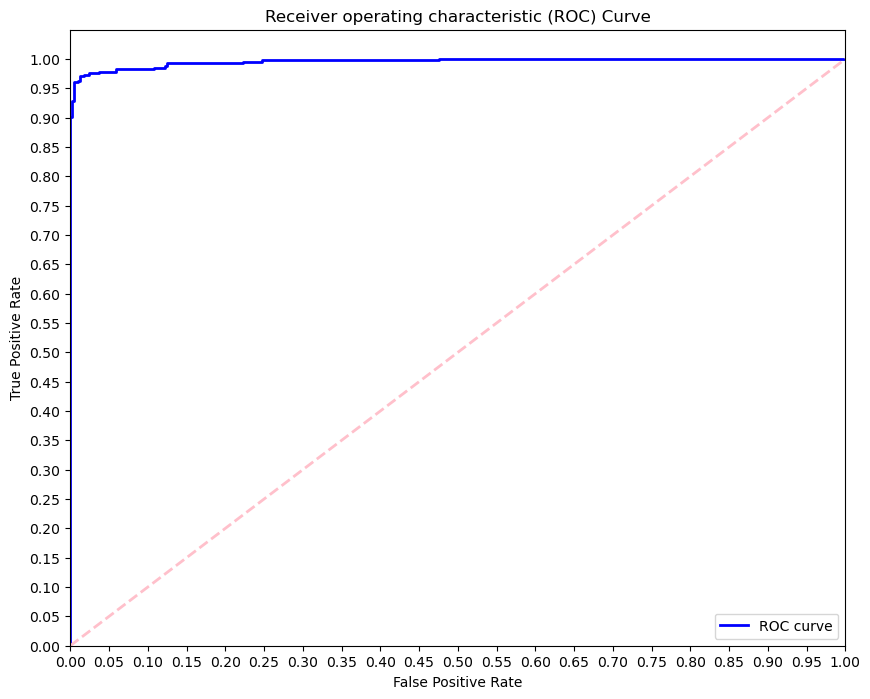

In [22]:
# Plotting the performance of model 1

plot_roc_auc(modelone_predsval[0], modelone_predsval[1])

The ROC curve above shows that the model learned incredibly fast with a true positive rate. The ROC curve peaks soon after some minor growth, but as time goes on, the false positive rate will continue to increase while the true positive plateaus.

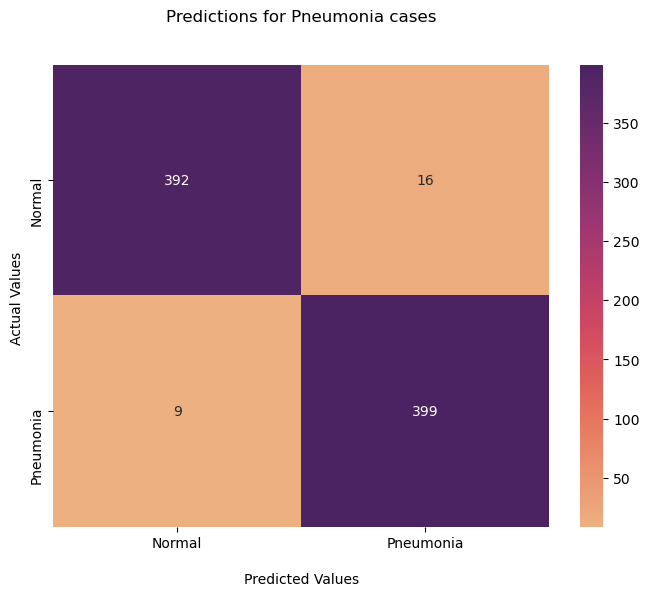

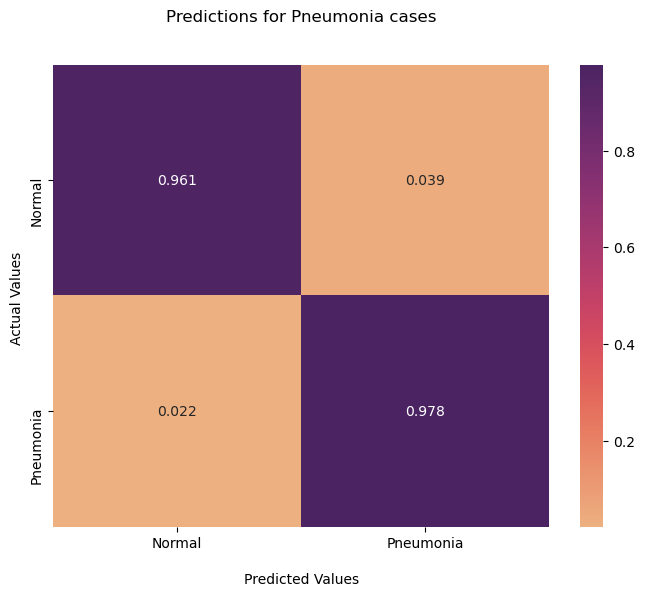

In [23]:
# Printing confusion matrix for validation set

conf_matrix(modelone_predsval[0], modelone_predsval[1])

This confusion matrix of the baseline model shows that there are 97.8% true positives, and 2.2% are false negatives, which represents the amount of patients not getting diagnosed. This is okay, but not reliable enough for this use case. Out of the patients with normal X-Ray images, 3.9% are false positives. It is better that the percentage of false positives is higher than the percentage of false negatives.

### HParams

In [24]:
# Creating the hparam variables

HP_NUM_UNITS = hp.HParam('num_units', hp.Discrete([64, 128]))
HP_DROPOUT = hp.HParam('dropout_rate', hp.RealInterval(0.1, 0.2))
HP_OPTIMIZER = hp.HParam('optimizer', hp.Discrete(['adam', 'rmsprop']))
HP_LEARNING_RATE = hp.HParam('learning_rate', hp.Discrete([0.01, 0.001, 0.0001]))
METRIC_ACCURACY = 'binary_accuracy'

In [25]:
#Creating a directory for logs

logdir = 'logs/hparam_tuning'

In [26]:
# Creating a file writer for hyperparameter tuning

with tf.summary.create_file_writer('logs/hparam_tuning').as_default():
  hp.hparams_config(
    hparams=[HP_NUM_UNITS, HP_DROPOUT, HP_OPTIMIZER, HP_LEARNING_RATE],
    metrics=[hp.Metric(METRIC_ACCURACY, display_name='binary_accuracy')],
  )

In [27]:
# The function below uses the baseline model as it's base model. It changes the nodes, optimizer, dropout and 
# learning rate based on the set params in the HParams. 
    
# Creating function to do an HParams search
def create_model_grid(hparams):
    #Initializing model
    model = models.Sequential()
    
    #Adding CNN input layer
    model.add(layers.Conv2D(32, (3,3), activation = 'relu', input_shape = (224, 224, 3)))
    model.add(layers.MaxPooling2D(2,2))
    model.add(layers.Dropout(hparams[HP_DROPOUT]))
    
    #Adding Dense hidden layer
    model.add(layers.Flatten())
    model.add(layers.Dense(hparams[HP_NUM_UNITS], activation = 'relu'))
    model.add(layers.Dropout(hparams[HP_DROPOUT]))
    
    #Adding output layer
    model.add(layers.Dense(1, activation = 'sigmoid'))
    
    #Looping through optimizers and learning rates
    optimizer = hparams[HP_OPTIMIZER]
    learning_rate = hparams[HP_LEARNING_RATE]
    if optimizer == "adam":
        optimizer = tf.optimizers.Adam(learning_rate=learning_rate)
    elif optimizer=='rmsprop':
        optimizer = tf.optimizers.RMSprop(learning_rate=learning_rate)
    else:
        raise ValueError("unexpected optimizer name: %r" % (optimizer_name,))
    
    #Compiling model
    model.compile(loss= 'binary_crossentropy', 
    optimizer= optimizer, 
    metrics= tf.keras.metrics.BinaryAccuracy(name="binary_accuracy", dtype=None, threshold=0.5))
    
    #Fitting model
    history=model.fit(
    train_generator, #Using train data
    steps_per_epoch=100, #Keeping 100 steps
    epochs=10, #Keeping 10 epochs
    validation_data=validation_generator, #Using validation data
    class_weight = class_weight, #Adding weights to deal with imbalance
    validation_steps=10, #Keeping 10 steps
    )
    
    return history.history['val_binary_accuracy'][-1]

In [28]:
# Creating run function

def run(run_dir, hparams):
  with tf.summary.create_file_writer(run_dir).as_default():
    hp.hparams(hparams)  # record the values used in this trial
    accuracy = create_model_grid(hparams)
    tf.summary.scalar(METRIC_ACCURACY, accuracy, step=1)

In [29]:
# Running hparams model

session_num = 0

for num_units in HP_NUM_UNITS.domain.values:
  for dropout_rate in (HP_DROPOUT.domain.min_value, HP_DROPOUT.domain.max_value):
    for optimizer in HP_OPTIMIZER.domain.values:
        for learning_rate in HP_LEARNING_RATE.domain.values:
            hparams = {
              HP_NUM_UNITS: num_units,
              HP_DROPOUT: dropout_rate,
              HP_OPTIMIZER: optimizer,
              HP_LEARNING_RATE: learning_rate
              }
            run_name = "run-%d" % session_num
            print('--- Starting trial: %s' % run_name)
            print({h.name: hparams[h] for h in hparams})
            run('logs/hparam_tuning/' + run_name, hparams)
            session_num += 1

--- Starting trial: run-0
{'num_units': 64, 'dropout_rate': 0.1, 'optimizer': 'adam', 'learning_rate': 0.0001}
Epoch 1/10
100/100 [==============================] - 106s 1s/step - loss: 0.1939 - binary_accuracy: 0.7475 - val_loss: 0.3922 - val_binary_accuracy: 0.8500
Epoch 2/10
100/100 [==============================] - 104s 1s/step - loss: 0.1122 - binary_accuracy: 0.8772 - val_loss: 0.2609 - val_binary_accuracy: 0.9094
Epoch 3/10
100/100 [==============================] - 104s 1s/step - loss: 0.0804 - binary_accuracy: 0.9128 - val_loss: 0.2032 - val_binary_accuracy: 0.9281
Epoch 4/10
100/100 [==============================] - 106s 1s/step - loss: 0.0664 - binary_accuracy: 0.9269 - val_loss: 0.1454 - val_binary_accuracy: 0.9594
Epoch 5/10
100/100 [==============================] - 104s 1s/step - loss: 0.0604 - binary_accuracy: 0.9431 - val_loss: 0.1412 - val_binary_accuracy: 0.9625
Epoch 6/10
100/100 [==============================] - 106s 1s/step - loss: 0.0602 - binary_accuracy: 0.9

100/100 [==============================] - 121s 1s/step - loss: 0.0602 - binary_accuracy: 0.9681 - val_loss: 0.1110 - val_binary_accuracy: 0.9750
Epoch 10/10
100/100 [==============================] - 121s 1s/step - loss: 0.0498 - binary_accuracy: 0.9731 - val_loss: 0.1030 - val_binary_accuracy: 0.9688
--- Starting trial: run-5
{'num_units': 64, 'dropout_rate': 0.1, 'optimizer': 'rmsprop', 'learning_rate': 0.01}
Epoch 1/10
100/100 [==============================] - 121s 1s/step - loss: 14.4243 - binary_accuracy: 0.7294 - val_loss: 0.4133 - val_binary_accuracy: 0.8406
Epoch 2/10
100/100 [==============================] - 119s 1s/step - loss: 1.0195 - binary_accuracy: 0.7987 - val_loss: 0.6158 - val_binary_accuracy: 0.7063
Epoch 3/10
100/100 [==============================] - 120s 1s/step - loss: 0.5477 - binary_accuracy: 0.7728 - val_loss: 0.6933 - val_binary_accuracy: 0.5031
Epoch 4/10
100/100 [==============================] - 120s 1s/step - loss: 0.2330 - binary_accuracy: 0.7403 - va

Epoch 8/10
100/100 [==============================] - 113s 1s/step - loss: 0.0425 - binary_accuracy: 0.9513 - val_loss: 0.1080 - val_binary_accuracy: 0.9625
Epoch 9/10
100/100 [==============================] - 113s 1s/step - loss: 0.0406 - binary_accuracy: 0.9528 - val_loss: 0.1048 - val_binary_accuracy: 0.9719
Epoch 10/10
100/100 [==============================] - 114s 1s/step - loss: 0.0346 - binary_accuracy: 0.9591 - val_loss: 0.0948 - val_binary_accuracy: 0.9594
--- Starting trial: run-10
{'num_units': 64, 'dropout_rate': 0.2, 'optimizer': 'rmsprop', 'learning_rate': 0.001}
Epoch 1/10
100/100 [==============================] - 115s 1s/step - loss: 0.9749 - binary_accuracy: 0.7769 - val_loss: 0.1953 - val_binary_accuracy: 0.9281
Epoch 2/10
100/100 [==============================] - 112s 1s/step - loss: 0.1856 - binary_accuracy: 0.9072 - val_loss: 0.1446 - val_binary_accuracy: 0.9469
Epoch 3/10
100/100 [==============================] - 112s 1s/step - loss: 0.1002 - binary_accuracy:

100/100 [==============================] - 117s 1s/step - loss: 0.0367 - binary_accuracy: 0.9616 - val_loss: 0.6740 - val_binary_accuracy: 0.8156
Epoch 7/10
100/100 [==============================] - 114s 1s/step - loss: 0.0212 - binary_accuracy: 0.9775 - val_loss: 0.6868 - val_binary_accuracy: 0.8219
Epoch 8/10
100/100 [==============================] - 115s 1s/step - loss: 0.0123 - binary_accuracy: 0.9878 - val_loss: 0.8984 - val_binary_accuracy: 0.8219
Epoch 9/10
100/100 [==============================] - 117s 1s/step - loss: 0.0196 - binary_accuracy: 0.9816 - val_loss: 0.8231 - val_binary_accuracy: 0.8469
Epoch 10/10
100/100 [==============================] - 114s 1s/step - loss: 0.0159 - binary_accuracy: 0.9819 - val_loss: 0.5181 - val_binary_accuracy: 0.8406
--- Starting trial: run-15
{'num_units': 128, 'dropout_rate': 0.1, 'optimizer': 'rmsprop', 'learning_rate': 0.0001}
Epoch 1/10
100/100 [==============================] - 135s 1s/step - loss: 0.3802 - binary_accuracy: 0.6616 -

100/100 [==============================] - 116s 1s/step - loss: 0.0148 - binary_accuracy: 0.9844 - val_loss: 0.1990 - val_binary_accuracy: 0.9156
Epoch 5/10
100/100 [==============================] - 119s 1s/step - loss: 0.0112 - binary_accuracy: 0.9891 - val_loss: 0.0931 - val_binary_accuracy: 0.9688
Epoch 6/10
100/100 [==============================] - 116s 1s/step - loss: 0.0093 - binary_accuracy: 0.9909 - val_loss: 0.1036 - val_binary_accuracy: 0.9719
Epoch 7/10
100/100 [==============================] - 115s 1s/step - loss: 0.0039 - binary_accuracy: 0.9975 - val_loss: 0.1424 - val_binary_accuracy: 0.9500
Epoch 8/10
100/100 [==============================] - 120s 1s/step - loss: 0.0022 - binary_accuracy: 0.9981 - val_loss: 0.1504 - val_binary_accuracy: 0.9531
Epoch 9/10
100/100 [==============================] - 118s 1s/step - loss: 0.0021 - binary_accuracy: 0.9987 - val_loss: 0.1702 - val_binary_accuracy: 0.9469
Epoch 10/10
100/100 [==============================] - 119s 1s/step -

**Here are some of the best parameters below.**

run-4  
{'num_units': 64, 'dropout_rate': 0.1, 'optimizer': 'rmsprop', 'learning_rate': 0.001}  
84s 839ms/step - loss: 0.0478 - binary_accuracy: 0.9681 - val_loss: 0.1161 - val_binary_accuracy: 0.9625

run-6  
{'num_units': 64, 'dropout_rate': 0.2, 'optimizer': 'adam', 'learning_rate': 0.0001}  
79s 790ms/step - loss: 0.0243 - binary_accuracy: 0.9759 - val_loss: 0.0816 - val_binary_accuracy: 0.9750

run-21  
{'num_units': 128, 'dropout_rate': 0.2, 'optimizer': 'rmsprop', 'learning_rate': 0.0001}  
89s 889ms/step - loss: 0.0358 - binary_accuracy: 0.9625 - val_loss: 0.0964 - val_binary_accuracy: 0.9750

The best runs of the model are above. The best optimizer is adam, and the best dropout rate is 0.2. Run 6 is the best parameters out of the 3, because the binary accuracy is highest of 0.9759, and the binary accuracy of the validation set is *very* close at 0.9750. This means that the model is not overfitting, and is performing well with train *and* validation data. Now that we know which run has the best parameters, those parameters are what I will use to tune the model. 

### Tuning HParams

In [30]:
# Instantiating model 2

model2 = models.Sequential()
    
#Adding CNN input layer
model2.add(layers.Conv2D(32, (3,3), activation = 'relu', input_shape = (224, 224, 3)))
model2.add(layers.MaxPooling2D(2,2))

# Adding 0.2 to .Dropout since that was the best dropout parameter
model2.add(layers.Dropout(0.2))
    
#Adding Dense hidden layer
model2.add(layers.Flatten())

# Adding best num_units to dense layer
model2.add(layers.Dense(64, activation = 'relu'))
model2.add(layers.Dropout(0.2))
    
#Adding output layer
model2.add(layers.Dense(1, activation = 'sigmoid'))
  
#Looping through optimizers and learning rates

#Compiling model
model2.compile(loss= 'binary_crossentropy', 
optimizer= optimizers.Adam(lr = 1e-4), 
metrics= tf.keras.metrics.BinaryAccuracy(name="binary_accuracy", dtype=None, threshold=0.5))

In [31]:
# Printing the summary for model 2

model2.summary()

Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_25 (Conv2D)           (None, 222, 222, 32)      896       
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 111, 111, 32)      0         
_________________________________________________________________
dropout_48 (Dropout)         (None, 111, 111, 32)      0         
_________________________________________________________________
flatten_25 (Flatten)         (None, 394272)            0         
_________________________________________________________________
dense_50 (Dense)             (None, 64)                25233472  
_________________________________________________________________
dropout_49 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_51 (Dense)             (None, 1)               

In [32]:
#Fitting model 2

history_hparams=model2.fit(
train_generator, #Using train data
steps_per_epoch=30, #Keeping 30 steps
epochs=10, #Keeping 10 epochs
validation_data=validation_generator, #Using validation data
class_weight = class_weight, #Adding weights to deal with imbalance
validation_steps=10, #Keeping 10 steps
)

Epoch 1/10
30/30 [==============================] - 38s 1s/step - loss: 0.4236 - binary_accuracy: 0.3500 - val_loss: 0.6931 - val_binary_accuracy: 0.4812
Epoch 2/10
30/30 [==============================] - 36s 1s/step - loss: 0.2343 - binary_accuracy: 0.7823 - val_loss: 0.6931 - val_binary_accuracy: 0.5031
Epoch 3/10
30/30 [==============================] - 37s 1s/step - loss: 0.2285 - binary_accuracy: 0.7969 - val_loss: 0.6931 - val_binary_accuracy: 0.4969
Epoch 4/10
30/30 [==============================] - 35s 1s/step - loss: 0.2298 - binary_accuracy: 0.7937 - val_loss: 0.6932 - val_binary_accuracy: 0.4906
Epoch 5/10
30/30 [==============================] - 36s 1s/step - loss: 0.2393 - binary_accuracy: 0.7698 - val_loss: 0.6932 - val_binary_accuracy: 0.4688
Epoch 6/10
30/30 [==============================] - 36s 1s/step - loss: 0.2319 - binary_accuracy: 0.4823 - val_loss: 0.6931 - val_binary_accuracy: 0.5125
Epoch 7/10
30/30 [==============================] - 36s 1s/step - loss: 0.23

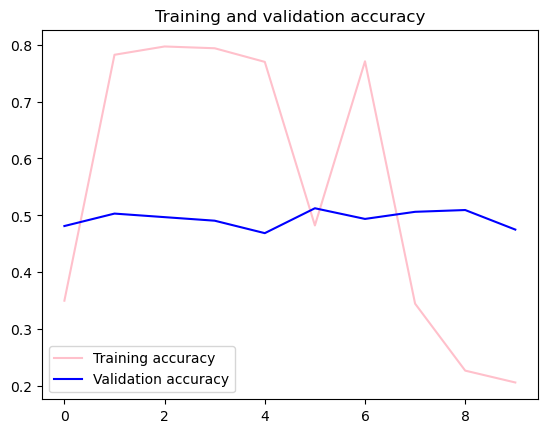

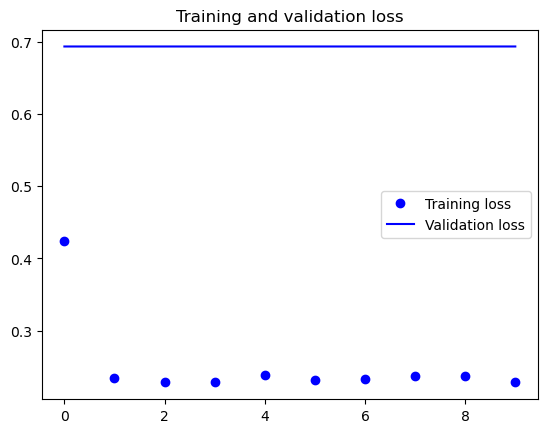

<Figure size 640x480 with 0 Axes>

In [33]:
# Calling the plot history function created earlier

plot_history(history_hparams)

With the graphs above of the accuracy and the loss function, the model typically wasn't running like this. I haven't ran it again, but I will continue to dry a different model.

In the top graph above, the validation and training accuracy are plotted. The training accuracy curve is a much smoother curve than the validation curve, which means this second model is performing better on the validation set, but still not optimal performance. In the bottom graph that's above, the training loss and validation loss are plotted. The training loss shows how well the model is fitting the training data, and the validation loss shows how well the model fits new data. That being said, there is room to improve, so I'm going to check the predictions to determine next steps.

### HParams Predictions Check

In [34]:
model2_predsval = pred_labels(model2, validation_generator)

In [61]:
model2_predsval[1]

[0.4998924,
 0.4998924,
 0.4998924,
 0.4998924,
 0.4998924,
 0.4998924,
 0.4998924,
 0.4998924,
 0.4998924,
 0.4998924,
 0.4998924,
 0.4998924,
 0.4998924,
 0.4998924,
 0.4998924,
 0.4998924,
 0.4998924,
 0.4998924,
 0.4998924,
 0.4998924,
 0.4998924,
 0.4998924,
 0.4998924,
 0.4998924,
 0.4998924,
 0.4998924,
 0.4998924,
 0.4998924,
 0.4998924,
 0.4998924,
 0.4998924,
 0.4998924,
 0.4998924,
 0.4998924,
 0.4998924,
 0.4998924,
 0.4998924,
 0.4998924,
 0.4998924,
 0.4998924,
 0.4998924,
 0.4998924,
 0.4998924,
 0.4998924,
 0.4998924,
 0.4998924,
 0.4998924,
 0.4998924,
 0.4998924,
 0.4998924,
 0.4998924,
 0.4998924,
 0.4998924,
 0.4998924,
 0.4998924,
 0.4998924,
 0.4998924,
 0.4998924,
 0.4998924,
 0.4998924,
 0.4998924,
 0.4998924,
 0.4998924,
 0.4998924,
 0.4998924,
 0.4998924,
 0.4998924,
 0.4998924,
 0.4998924,
 0.4998924,
 0.4998924,
 0.4998924,
 0.4998924,
 0.4998924,
 0.4998924,
 0.4998924,
 0.4998924,
 0.4998924,
 0.4998924,
 0.4998924,
 0.4998924,
 0.4998924,
 0.4998924,
 0.4

AUC: 0.5


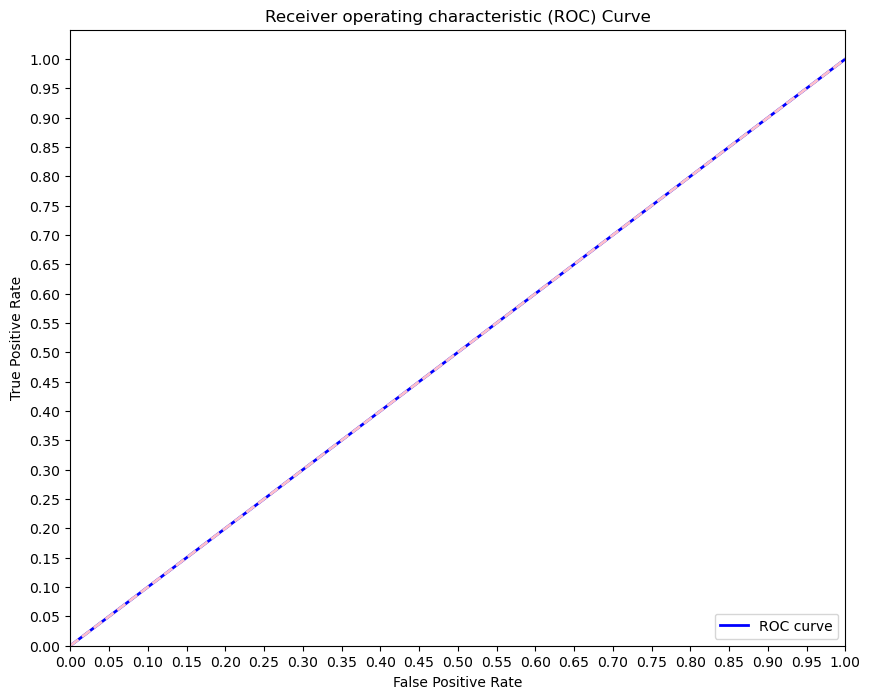

In [35]:
plot_roc_auc(model2_predsval[0], model2_predsval[1])

I'm not quite sure what went wrong with this model, because previously it didn't run this way, but regardless, I'm going to continue trying different models.

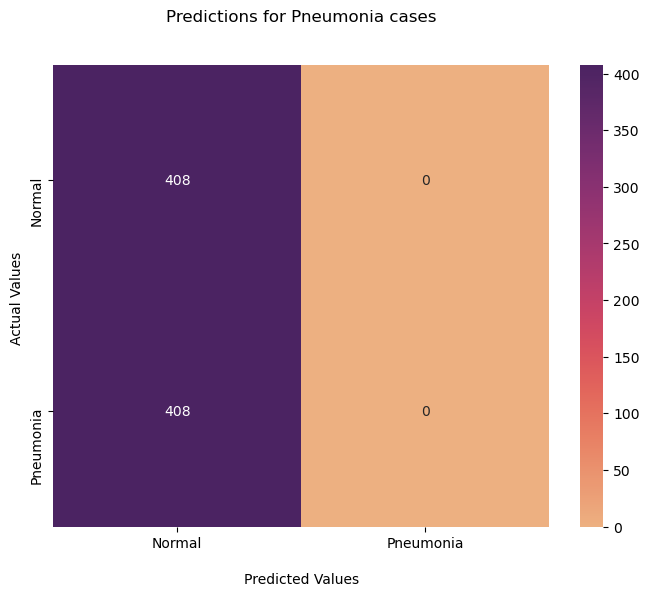

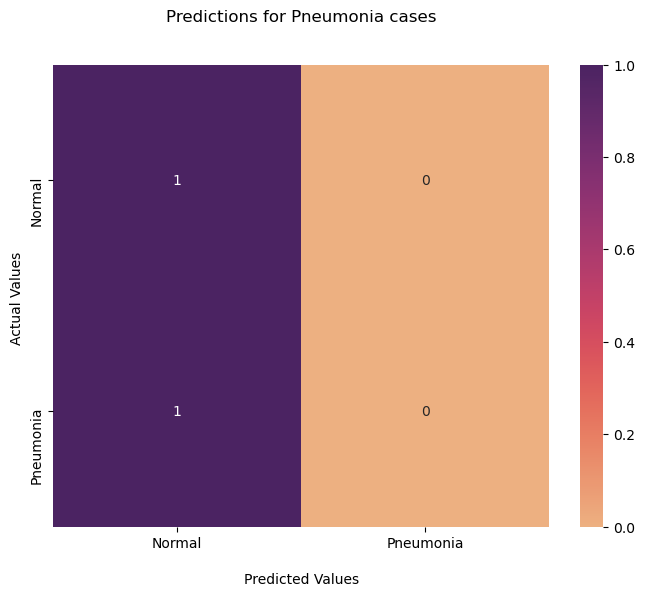

In [62]:
conf_matrix(model2_predsval[0], model2_predsval[1])

The confusion matrices above aren't showing the results we would like. False negatives and false positives seem to have switched places since the baseline model. 14.2% of patients with pneumonia are predicted to not have it, but the false positive rate is much lower than the. baseline at 0.5%. However, like I mentioned before, in healthcare cases, it's best to have more false positives than it is false negatives.

### Transfer Learning

**Inception-V3**

In [37]:
# Instantiating model 3

model3 = models.Sequential()

# Creating an inception v3 model

inception_v3 = tf.keras.applications.InceptionV3(
    include_top=False,
    weights="imagenet",
    input_shape=(224, 224, 3),
    classes=1
)

for layer in inception_v3.layers:
    layer.trainable = False

model3.add(inception_v3)

In [38]:
model3.add(layers.GlobalAveragePooling2D())
model3.add(layers.Dense(64, activation = 'relu'))
model3.add(layers.Dropout(0.2))

#Adding output layer
model3.add(layers.Dense(1, activation = 'sigmoid'))

In [39]:
# Compiling model
model3.compile(loss= 'binary_crossentropy', 
optimizer= optimizers.Adam(lr = 1e-4), 
metrics= tf.keras.metrics.BinaryAccuracy(name="binary_accuracy", dtype=None, threshold=0.5))

In [40]:
model3.summary()

Model: "sequential_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 5, 5, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense_52 (Dense)             (None, 64)                131136    
_________________________________________________________________
dropout_50 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_53 (Dense)             (None, 1)                 65        
Total params: 21,933,985
Trainable params: 131,201
Non-trainable params: 21,802,784
_________________________________________________________________


In [41]:
#Fitting model 3

history_transfer=model3.fit(
train_generator, #Using train data
steps_per_epoch=30, #Keeping 30 steps
epochs=10, #Keeping 10 epochs
validation_data=validation_generator, #Using validation data
class_weight = class_weight, #Adding weights to deal with imbalance
validation_steps=10, #Keeping 10 steps
)

Epoch 1/10
30/30 [==============================] - 44s 1s/step - loss: 0.2123 - binary_accuracy: 0.6969 - val_loss: 0.4334 - val_binary_accuracy: 0.8625
Epoch 2/10
30/30 [==============================] - 38s 1s/step - loss: 0.1454 - binary_accuracy: 0.8031 - val_loss: 0.3393 - val_binary_accuracy: 0.8844
Epoch 3/10
30/30 [==============================] - 38s 1s/step - loss: 0.1217 - binary_accuracy: 0.8479 - val_loss: 0.2948 - val_binary_accuracy: 0.9094
Epoch 4/10
30/30 [==============================] - 38s 1s/step - loss: 0.1043 - binary_accuracy: 0.8771 - val_loss: 0.2685 - val_binary_accuracy: 0.8938
Epoch 5/10
30/30 [==============================] - 37s 1s/step - loss: 0.0988 - binary_accuracy: 0.8833 - val_loss: 0.2698 - val_binary_accuracy: 0.9062
Epoch 6/10
30/30 [==============================] - 36s 1s/step - loss: 0.0893 - binary_accuracy: 0.8823 - val_loss: 0.2452 - val_binary_accuracy: 0.8969
Epoch 7/10
30/30 [==============================] - 40s 1s/step - loss: 0.08

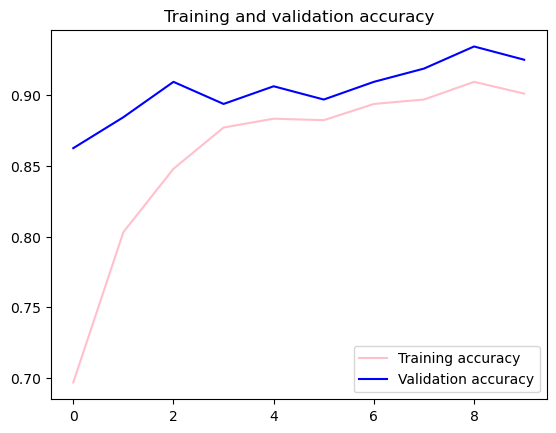

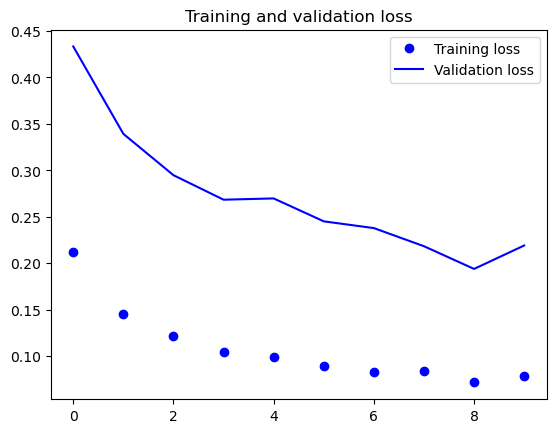

<Figure size 640x480 with 0 Axes>

In [42]:
# Calling the plot history function for the transfer tuning model

plot_history(history_transfer)

### Transfer Learning Predictions Check

In [43]:
model3_predsval = pred_labels(model3, validation_generator)

AUC: 0.9773464532871973


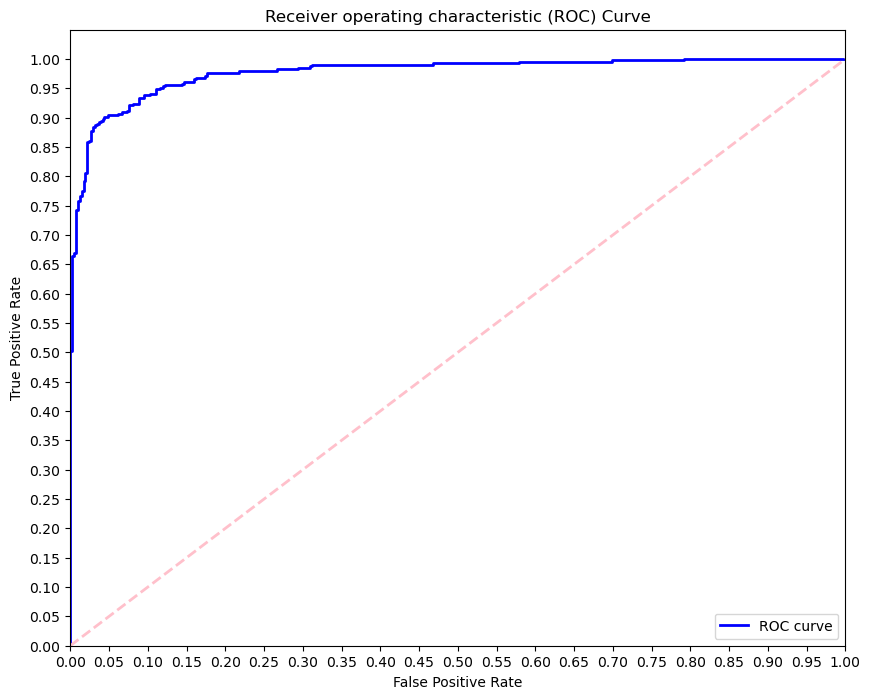

In [44]:
plot_roc_auc(model3_predsval[0], model3_predsval[1])

This graph of the ROC/AUC curve shows a slightly different ROC curve than the previous models. The elbow doesn't occur quite as blatantly or as soon, but it does climb to a higher point than the previous models.

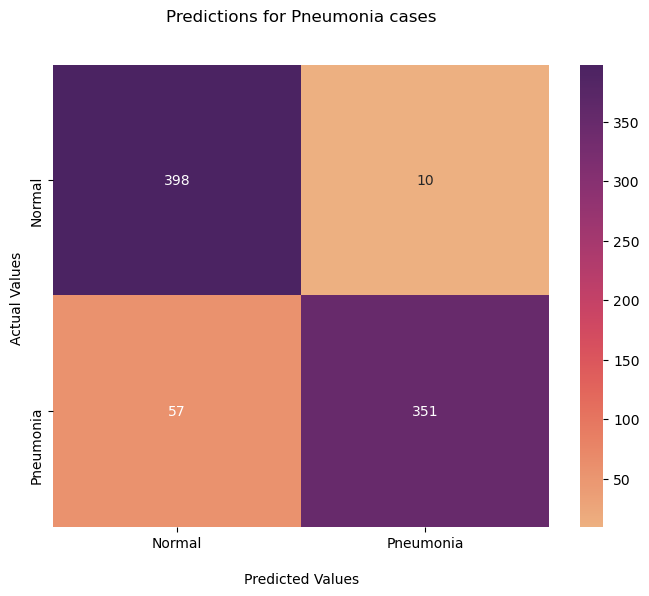

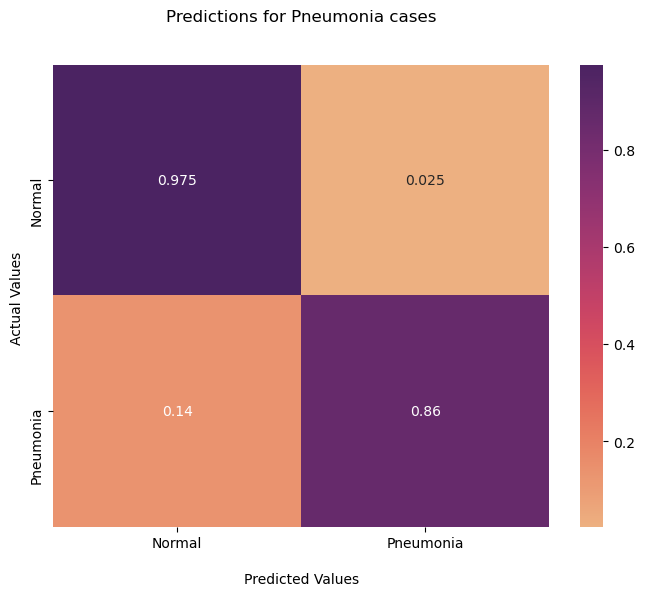

In [45]:
conf_matrix(model3_predsval[0], model3_predsval[1])

This confusion matrix shows better results than the second model, but still doesn't have as few false negatives as the baseline model. However, there is still a 95.1% true positive rate. Now, I'm going to tune the transfer learning model, just like I did with HParams.

### Transfer Learning Tuned

In [46]:
# Instantiating model 4

model4 = models.Sequential()

inception_v3_tuned = tf.keras.applications.InceptionV3(
    include_top=False,
    weights="imagenet",
    input_shape=(224, 224, 3),
    classes=1
)


for layer in inception_v3_tuned.layers[:-31]:
    layer.trainable = False

for i, layer in enumerate(inception_v3_tuned.layers):
    print(i, layer.name, layer.trainable)

0 input_2 False
1 conv2d_120 False
2 batch_normalization_94 False
3 activation_94 False
4 conv2d_121 False
5 batch_normalization_95 False
6 activation_95 False
7 conv2d_122 False
8 batch_normalization_96 False
9 activation_96 False
10 max_pooling2d_30 False
11 conv2d_123 False
12 batch_normalization_97 False
13 activation_97 False
14 conv2d_124 False
15 batch_normalization_98 False
16 activation_98 False
17 max_pooling2d_31 False
18 conv2d_128 False
19 batch_normalization_102 False
20 activation_102 False
21 conv2d_126 False
22 conv2d_129 False
23 batch_normalization_100 False
24 batch_normalization_103 False
25 activation_100 False
26 activation_103 False
27 average_pooling2d_9 False
28 conv2d_125 False
29 conv2d_127 False
30 conv2d_130 False
31 conv2d_131 False
32 batch_normalization_99 False
33 batch_normalization_101 False
34 batch_normalization_104 False
35 batch_normalization_105 False
36 activation_99 False
37 activation_101 False
38 activation_104 False
39 activation_105 False


In [47]:
# Input Layer

model4.add(inception_v3_tuned)

# Hidden Layer
model4.add(layers.GlobalAveragePooling2D())
model4.add(layers.Dense(64, activation = 'relu'))
model4.add(layers.Dropout(0.2))

#Adding output layer
model4.add(layers.Dense(1, activation = 'sigmoid'))

In [48]:
# Compiling model
model4.compile(loss= 'binary_crossentropy', 
optimizer= optimizers.Adam(lr = 1e-4), 
metrics= tf.keras.metrics.BinaryAccuracy(name="binary_accuracy", dtype=None, threshold=0.5))

In [49]:
# Printing the summary for model 4

model4.summary()

Model: "sequential_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 5, 5, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dense_54 (Dense)             (None, 64)                131136    
_________________________________________________________________
dropout_51 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_55 (Dense)             (None, 1)                 65        
Total params: 21,933,985
Trainable params: 6,204,737
Non-trainable params: 15,729,248
_________________________________________________________________


In [50]:
#Fitting model

history_transfertune=model4.fit(
train_generator, #Using train data
steps_per_epoch=30, #Keeping 30 steps
epochs=10, #Keeping 10 epochs
validation_data=validation_generator, #Using validation data
class_weight = class_weight, #Adding weights to deal with imbalance
validation_steps=10, #Keeping 10 steps
)

Epoch 1/10
30/30 [==============================] - 45s 1s/step - loss: 0.1003 - binary_accuracy: 0.8833 - val_loss: 0.9740 - val_binary_accuracy: 0.6812
Epoch 2/10
30/30 [==============================] - 49s 2s/step - loss: 0.0418 - binary_accuracy: 0.9427 - val_loss: 1.2317 - val_binary_accuracy: 0.6594
Epoch 3/10
30/30 [==============================] - 48s 2s/step - loss: 0.0376 - binary_accuracy: 0.9563 - val_loss: 1.0510 - val_binary_accuracy: 0.7094
Epoch 4/10
30/30 [==============================] - 51s 2s/step - loss: 0.0417 - binary_accuracy: 0.9531 - val_loss: 0.6121 - val_binary_accuracy: 0.8062
Epoch 5/10
30/30 [==============================] - 51s 2s/step - loss: 0.0327 - binary_accuracy: 0.9719 - val_loss: 0.4077 - val_binary_accuracy: 0.8625
Epoch 6/10
30/30 [==============================] - 49s 2s/step - loss: 0.0290 - binary_accuracy: 0.9604 - val_loss: 0.2162 - val_binary_accuracy: 0.9219
Epoch 7/10
30/30 [==============================] - 50s 2s/step - loss: 0.02

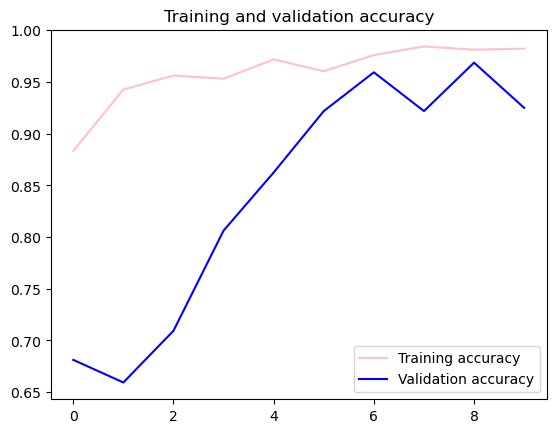

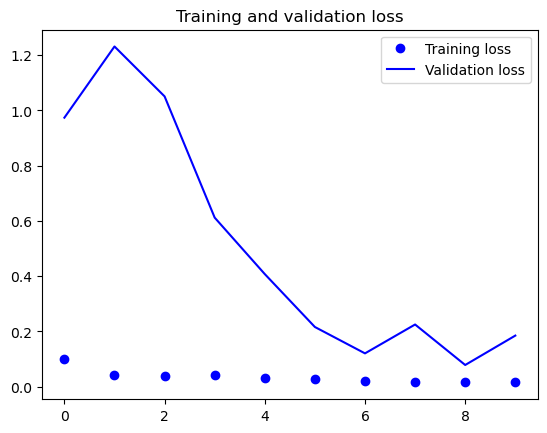

<Figure size 640x480 with 0 Axes>

In [51]:
# Plotting history for model one

plot_history(history_transfertune)

### Transfer Learning Predictions Check

In [52]:
# Calling pred_labels on model 4

model4_predsval = pred_labels(model4, validation_generator)

AUC: 0.9943591407151096


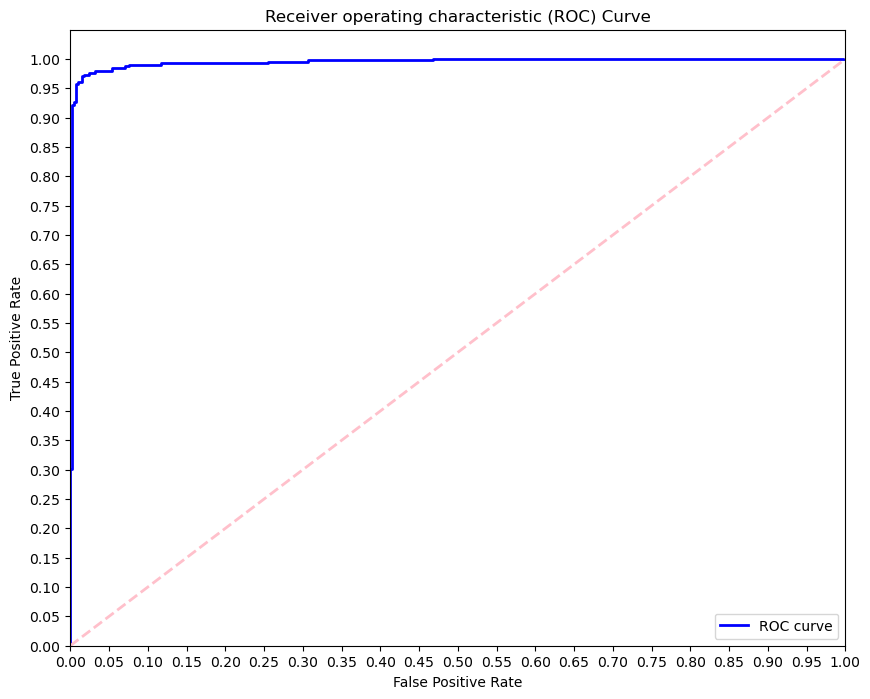

In [53]:
# Plotting the rocauc curbes with a function

plot_roc_auc(model4_predsval[0], model4_predsval[1])

This ROC/AUC curve shows one of the best ROC curves that I've achieved so far, with a 99.6% AUC.

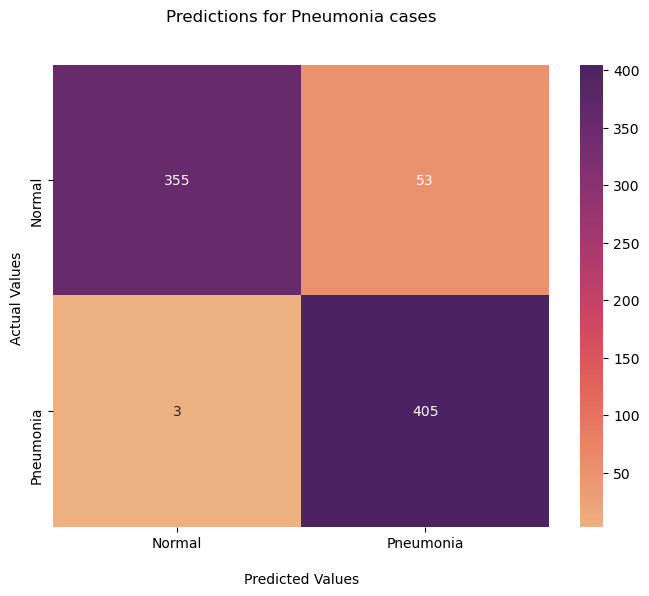

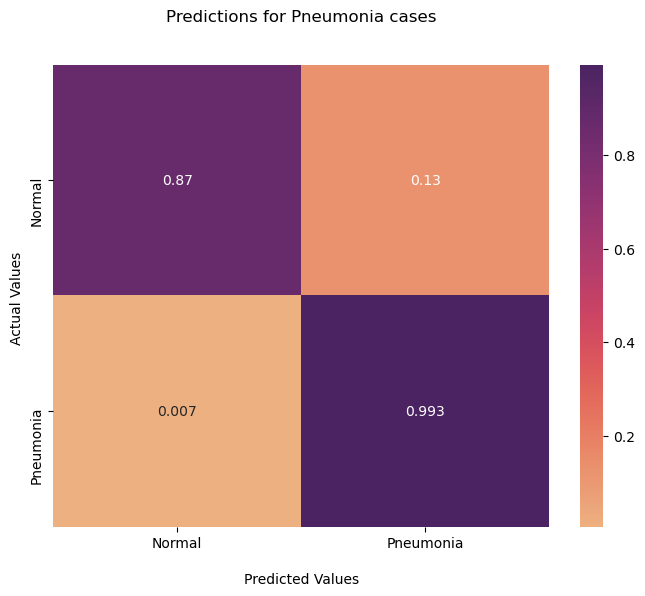

In [54]:
# Calling the confusion matrix function

conf_matrix(model4_predsval[0], model4_predsval[1])

The false negative rate in this confusion matrix for the tuned transfer learning model is 1.7%. The false positive rate is 5.6%, so still higher than the false negatives (which is good). The true positive rate is 98.3%.

In [55]:
model4.summary()

Model: "sequential_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 5, 5, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dense_54 (Dense)             (None, 64)                131136    
_________________________________________________________________
dropout_51 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_55 (Dense)             (None, 1)                 65        
Total params: 21,933,985
Trainable params: 6,204,737
Non-trainable params: 15,729,248
_________________________________________________________________


### Test generator

In [56]:
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(test_dir,
                                                        target_size=(224, 224),
                                                        batch_size=32,
                                                        class_mode='binary',
                                                        shuffle = True)

Found 624 images belonging to 2 classes.


In [57]:
final_preds = pred_labels(model4, test_generator)

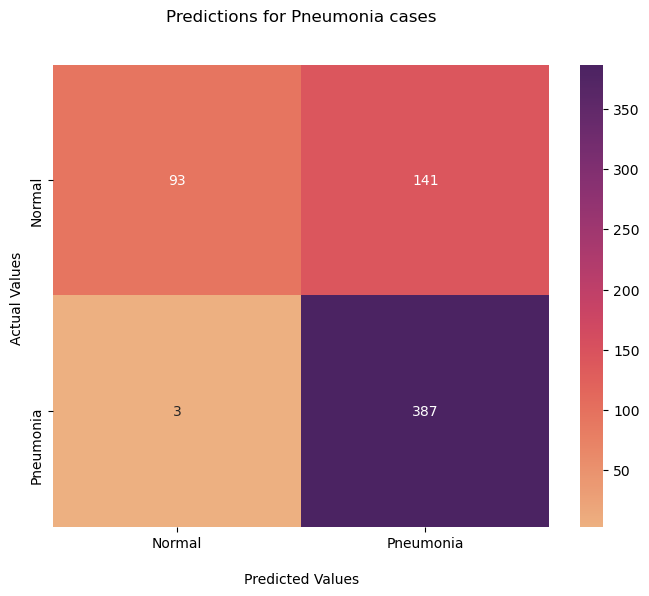

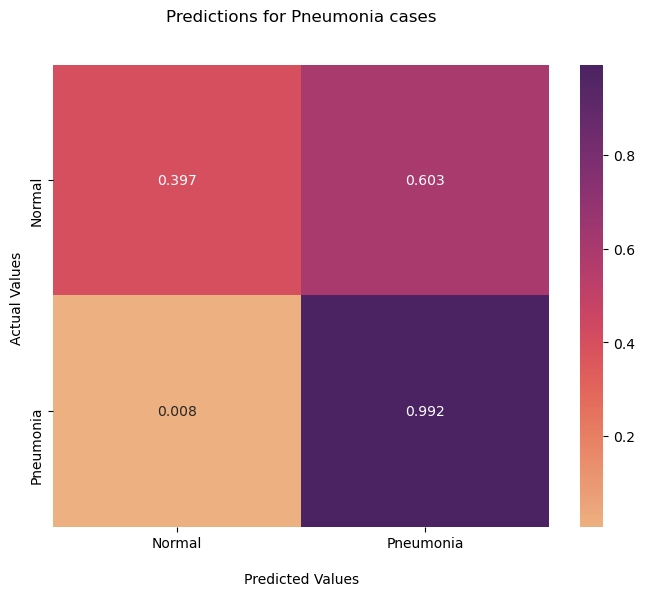

In [58]:
conf_matrix(final_preds[0], final_preds[1])

### Conclusion

After iterating through different types of possible models, the best model was Inception V3 tuned (model 4). I decided to use that model to test the test set. The model performed well on the train set and had a 99.2% true positive rate, and a .8% false negative rate. This is a result that I am happy with endorsing as using for a second opinion, or a tool to help flag pneumonia and diagnose patients faster. The AUC line had a score of 0.994. The AUC line measures the ability of the model to distinguish between classes, which is something I am satisfied with. The last epoch of the fourth model has a binary accuracy score of 0.9812, with a validation binary accuracy score of 0.9688. Although the binary accuracy score and the validation binary accuracy score could be closer together, that is still a good performance on the validation set. 

Some recommendatios I would make based on this notebook would be to use **Inception V3** as a model. In addition, there are actually several types of pneumonia. This notebook is only testing for whether or not pneumonia is present, but with more layers, different types of pneumonia could be classified as well. The reason neural networks were used for this, is because images are 3-dimensional, so they require models that are more complex. Since there isn't patient data, I'm not able to measure how diverse the demographics are, but I would recommend those be included in order to make sure the model is being trained on all ages, sexes, ethnicities, and backgrounds.